In [23]:
import pickle
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import statistics as st
import os
import glob
import scipy.optimize as opt
%matplotlib inline

In [428]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             if(file[:2]=="C2" or file[:2]=="C1" ):
                filelist.append(os.path.join(root,file))
    return filelist

def getValues(files,skip,nFiles=-1,findex=0,single=False):
    theone={}
    if(single):
        values={"time":np.array([]),"voltage":np.array([])}
        with open(files[findex]) as f:
            for i in range(0,skip):
                try:
                    next(f)
                except:
                    continue
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                values["time"]=np.append(values["time"],float(splitline[0]))
                values["voltage"]=np.append(values["voltage"],float(splitline[1]))
        theone[0]=values
        f.close()
        
    else:
        count=0
        for k in files:
            values={"time":np.array([]),"voltage":np.array([])}
            with open(k) as f:
                for i in range(0,skip):
                    try:
                        next(f)
                    except:
                        continue
                lines=f.readlines()
                for line in lines:
                    splitline=line.split(",")
                    values["time"]=np.append(values["time"],float(splitline[0]))
                    values["voltage"]=np.append(values["voltage"],float(splitline[1]))
            theone[count]=values
            count+=1
            f.close()
            if(nFiles==count): 
                break

    return theone

def getMultiEventValues(files,nFiles=-1,EventLim=-1):
    theone={}
    EventCount=1
    PointCount=1
    FileCount=0
    for k in files:
        values={}
        with open(k) as f:
            lines=f.readlines()
            info={}
            for line in lines:
                splitline=line.strip().split(",")
                if(splitline[0]=="Segments"):
                    info[splitline[0]]=int(splitline[1])
                    info[splitline[2]]=int(splitline[3])
                    continue

                if("time" in values.keys()):
                    values["time"]=np.append(values["time"],float(splitline[0]))
                    values["voltage"]=np.append(values["voltage"],float(splitline[1]))
                    
                    if(PointCount==info["SegmentSize"]):
                        theone[EventCount]=values.copy()
                        
                        values["time"]=np.array([])
                        values["voltage"]=np.array([])
                        EventCount+=1
                        PointCount=0
                    
                    PointCount+=1
                else:
                    if (splitline[0]=="Time"):
                        values["time"]=np.array([])
                        values["voltage"]=np.array([])
                        
                        print(f"Collecting data from {FileCount} ")
                    continue;
                if (EventCount==EventLim or (EventLim!=-1 and EventCount>EventLim)):
                    break
                    
                    
        FileCount+=1
        f.close()
        if(nFiles==FileCount): 
            break

    return theone

In [15]:
#files=ListofFiles("/media/ilker/Ilker_SSD/10_07bar 6_21_23/Osiloscope/16k_8k_7k/pulse_wide")
values=getValues(["/home/ilker/Desktop/C1--S2_277m-00000--00001_width--01502.csv"],skip=5)

In [16]:
print(values)

{0: {'time': array([-2.4000235e-05, -2.3998235e-05, -2.3996235e-05, ...,
        2.5997765e-05,  2.5999765e-05,  2.6001765e-05]), 'voltage': array([0.00035  , 0.0002525, 0.0002375, ..., 0.0003425, 0.0003675,
       0.00036  ])}}


In [21]:
vv=values[0]["voltage"]
1e-6/len(values[0]["voltage"])

3.999680025597952e-11

In [603]:
def Smoothing(data,itteration):
    S_time=np.zeros(len(data["time"]))
    S_amp=np.zeros(len(data["voltage"]))
    for t in range(len(data["time"])):
        if(t<itteration):
            S_time[t]=np.mean(data["time"][:t+1])
            S_amp[t]=np.mean(data["voltage"][:t+1])
        else:
            #S_amp[t]=np.sum(data["voltage"][t-itteration:t])/itteration
            #S_time[t]=np.sum(data["time"][t-itteration:t])/itteration
            S_amp[t]=np.mean(data["voltage"][t-itteration:t])
            S_time[t]=np.mean(data["time"][t-itteration:t])
    return S_amp,S_time



## Peak Finder for Osiloscope info
def PeakFinder(data,step=1e-9,threshold=-0.01):
    
    print("Running Peak Finder Algorithm ..")
    ## First Get the lenth of the time
    Length=len(data["voltage"])
    VoltageProfile=np.array([])
    TimeProfile=np.array([])
    
    ## Obtain the max and min time
    MinTime=np.min(data["time"])
    MaxTime=np.max(data["time"])
    
    
    #Start Time
    TempTime=MinTime
    
    print(f"Max time is {MaxTime}")
    print(f"Min time is {MinTime}")
    print(f"Event Length is {Length}")

    for i in range(0, Length):
        if(TempTime>MaxTime):
            print("Max Time is reached")
            break
            
        TimeMask=(data["time"]>=TempTime) & (data["time"]<TempTime+step ) 
        
        ## Check if there is any peak here
        if(np.sum(TimeMask)==0):
            TempTime=TempTime+step
            continue
         
        ## Obtain the minum
        Min=np.min(data["voltage"][TimeMask])
        VoltageMask=data["voltage"][TimeMask]==Min
        
        ## Only Negative Pulse
        if(Min<threshold and (not Min>0)):
            TimeProfile=np.append(TimeProfile,data["time"][TimeMask][VoltageMask])
            VoltageProfile=np.append(VoltageProfile,data["voltage"][TimeMask][VoltageMask])

        TempTime=TempTime+step 
    print(f"Number of Peaks is {len(TimeProfile)}")
    return TimeProfile,VoltageProfile



def PeaksPerUnitTime(TProf,StartTime,EndTime):
    Mask=(TProf>=StartTime) & (TProf<EndTime)
    return np.sum(Mask)
    
### Get Number of peaks per unit time

def gaussian1d(x,A,mu,sigma):
    return A*np.exp( - (x - mu)**2 / (2 * sigma**2))

def MultiPeakFit(values,step,threshold):
    mean=np.array([])
    std=np.array([])
    for value in values:
        v=PeakFinder(value,step,threshold)
        h1=np.histogram(vv[0],bins=40)

        p0=np.max(h1[1]),1e-5,1e-6
        xx=np.linspace(np.min(h1[1]),np.max(h1[1]),len(h1[0]))
        popt, pcov = opt.curve_fit(gaussian1d,xx,h1[0],p0,maxfev=10000)
        
        mean=np.append(mean,popt[1])
        std=np.append(std,popt[2])
    return mean,std



In [567]:
### Values for time and voltage , step in seconds and threshold in mv
kk=PeakFinder(values[0],step=2e-9,threshold=-0.001)
PeaksPerUnitTime(kk[0],-2e-5,-1.2e-5)

Running Peak Finder Algorithm ..
Max time is 2.6001765e-05
Min time is -2.4000235e-05
Event Length is 25002
Max Time is reached
Number of Peaks is 4898


61

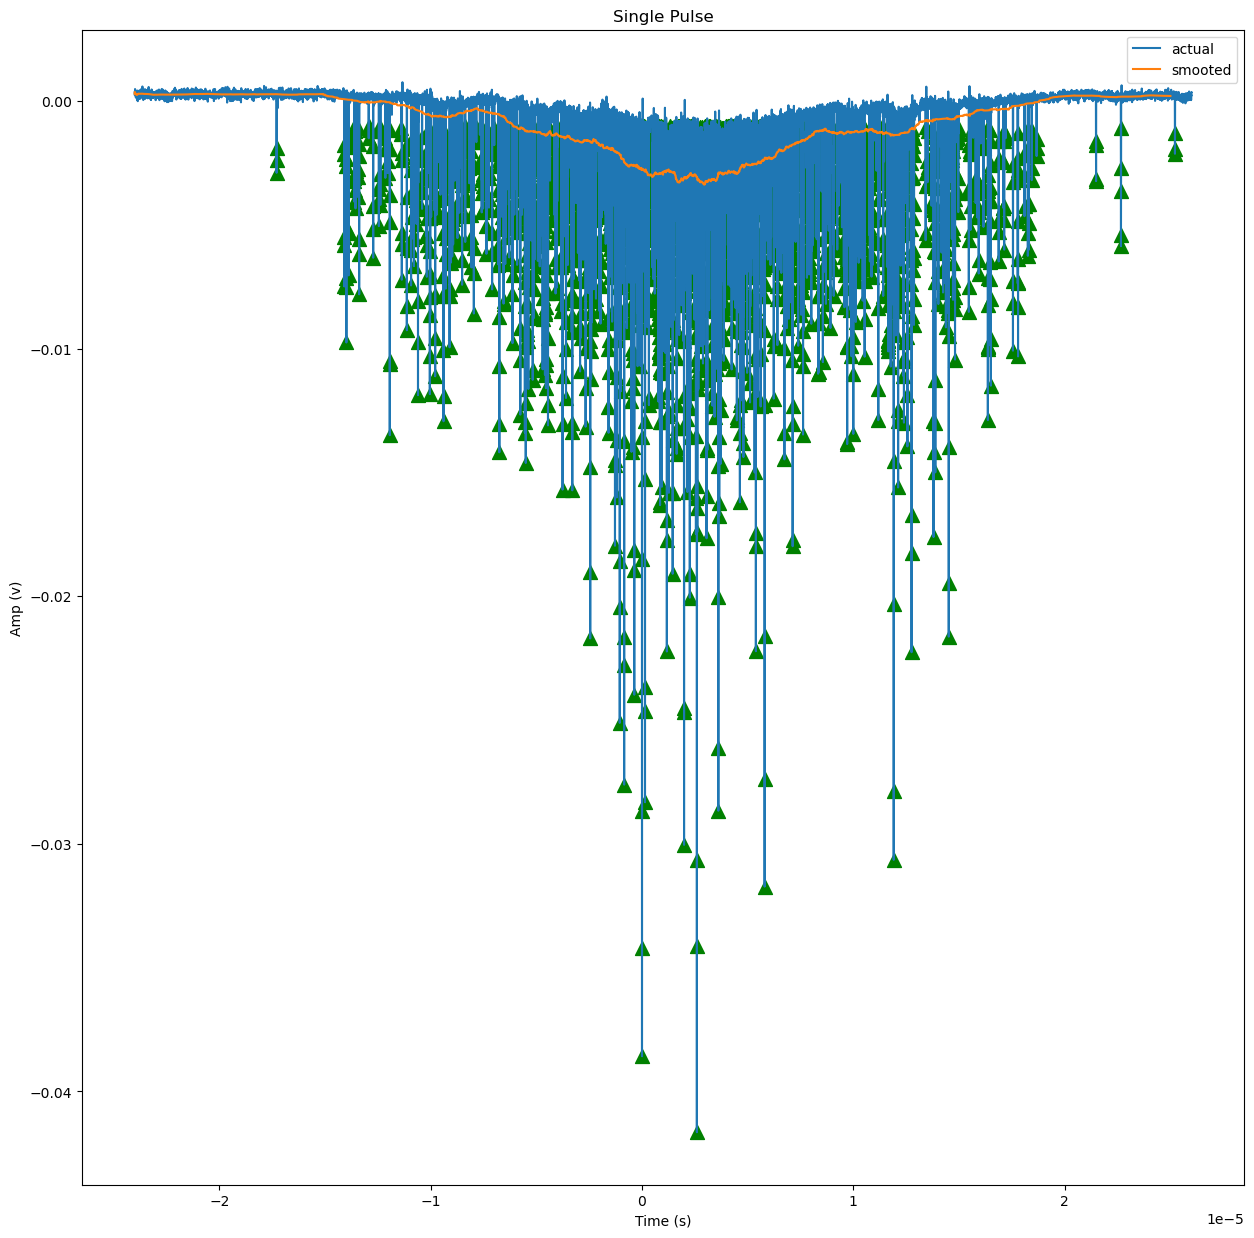

In [569]:
plt.figure(figsize=(15,15))
s1=Smoothing(values[0],1000)
plt.title("Single Pulse")
plt.xlabel("Time (s)")
plt.ylabel("Amp (v)")
plt.plot(values[0]["time"],values[0]["voltage"],label="actual")
plt.plot(s1[1],s1[0],label="smooted")
plt.scatter(kk[0],kk[1],marker="^",color="green",s=100)

#print(np.mean(vv))
plt.legend()
plt.show()


[4.18418648e+02 2.69564023e-06 4.55025241e-06]


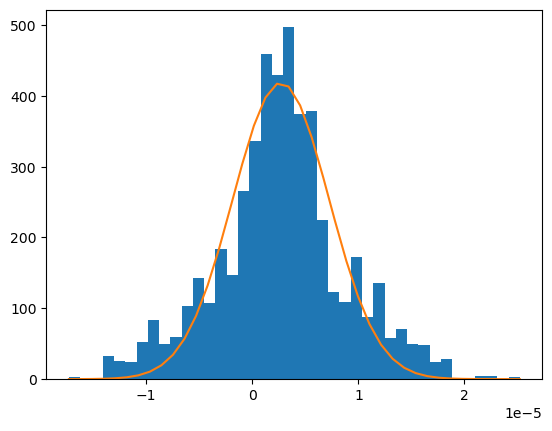

In [570]:
h1=plt.hist(kk[0],bins=40)

p0=np.max(h1[1]),1e-5,1e-6
xx=np.linspace(np.min(h1[1]),np.max(h1[1]),len(h1[0]))
popt, pcov = opt.curve_fit(gaussian1d,xx,h1[0],p0,maxfev=10000)  
print(popt)
plt.plot(xx,gaussian1d(xx,popt[0],popt[1],popt[2]))

In [630]:
multivalue=getMultiEventValues(["/home/ilker/Desktop/C1--S2_277m-00000--00001_width--00001.csv"],EventLim=5000)

In [597]:
vk=multivalue[10]
### Values for time and voltage , step in seconds and threshold in mv
mk=PeakFinder(vk,step=6e-8,threshold=-0.0002)
    


Running Peak Finder Algorithm ..
Max time is 5.960073e-06
Min time is -4.041927e-06
Event Length is 5002
Max Time is reached
Number of Peaks is 168


[-1.92806703e-02  1.11610770e-06  2.09391336e-06]


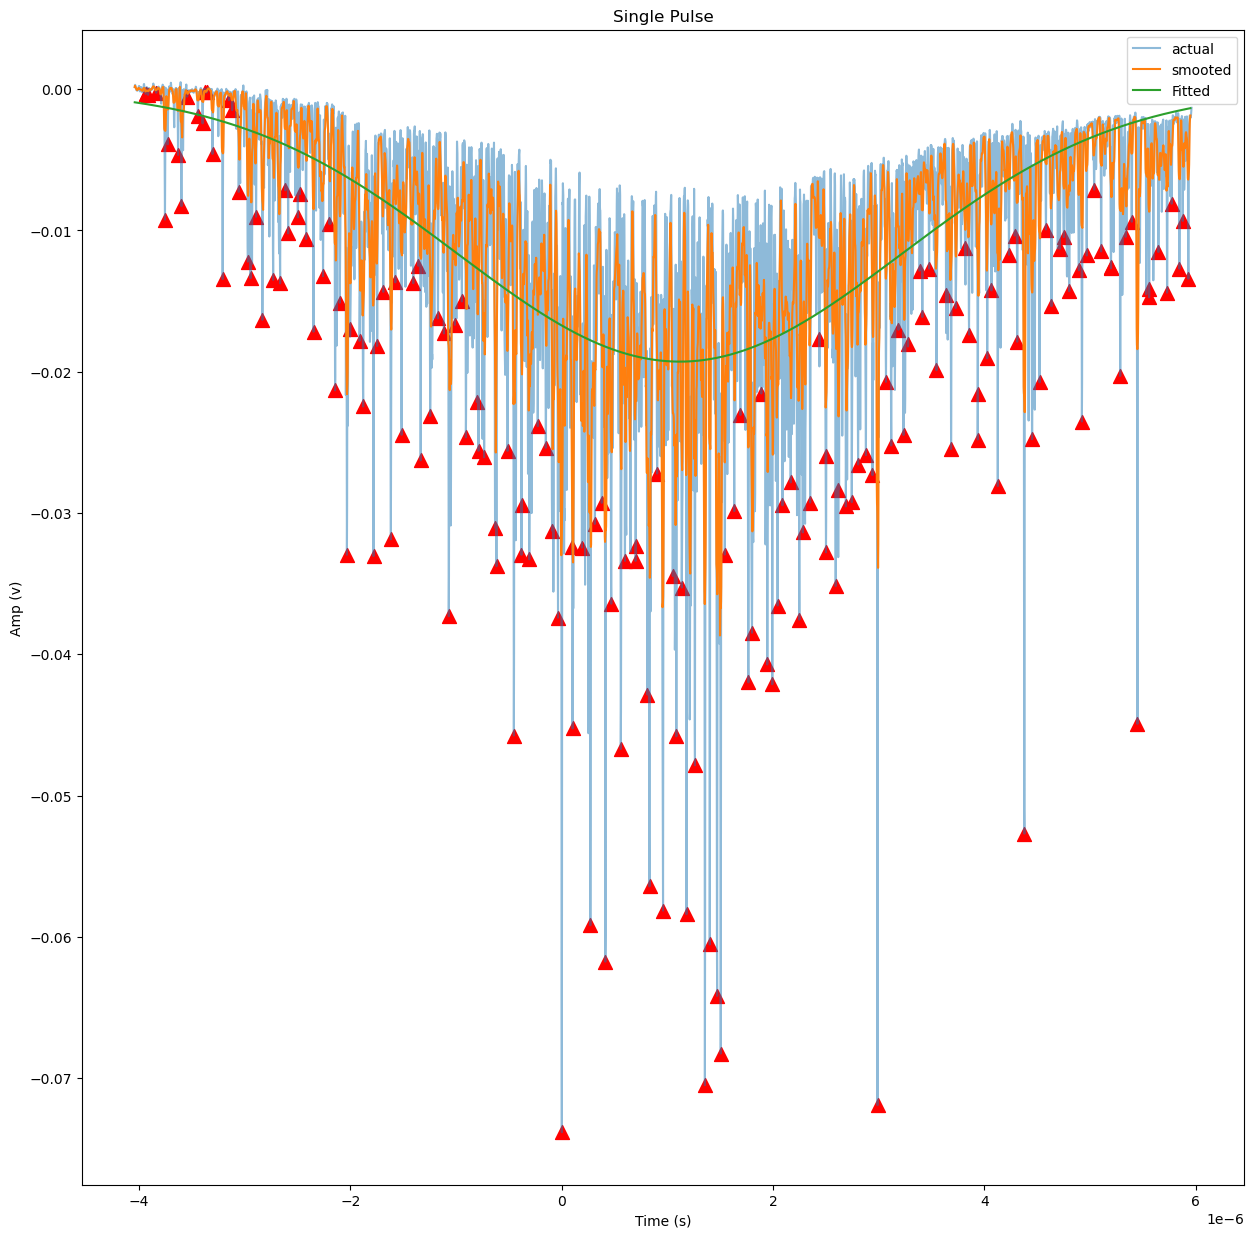

In [589]:
plt.figure(figsize=(15,15))
s1=Smoothing(vk,10)
plt.title("Single Pulse")
plt.xlabel("Time (s)")
plt.ylabel("Amp (v)")
plt.plot(vk["time"],vk["voltage"],label="actual",alpha=0.5)
plt.plot(s1[1],s1[0],label="smooted")
plt.scatter(mk[0],mk[1],marker="^",color="red",s=100)
p0=np.min(s1[0]),1e-5,1e-6
popt, pcov = opt.curve_fit(gaussian1d,s1[1],s1[0],p0,maxfev=10000) 
print(popt)
plt.plot(s1[1],gaussian1d(s1[1],popt[0],popt[1],popt[2]),label="Fitted")
#print(np.mean(vv))
plt.legend()
plt.show()

In [633]:
def MultiGausianFit(multival,mn,sg,maxfev=10000,SIteration=1000,vmin=-0.001):
    fmeans=np.array([])
    fstds=np.array([])
    for single in multival:
        ss=Smoothing(multival[single],SIteration)
        if(np.min(ss[0])<vmin):
            continue
        p0=np.min(ss[0]),mn,sg
        popt, pcov = opt.curve_fit(gaussian1d,ss[1],ss[0],p0,maxfev=maxfev)
        fmeans=np.append(fmeans,popt[1])
        fstds=np.append(fstds,popt[2])
    #plt.plot(s1[1],gaussian1d(s1[1],popt[0],popt[1],popt[2]),label="Fitted")
    return fmeans,fstds

In [634]:
mval=MultiGausianFit(multivalue,1e-5,1e-6)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  4.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 25., 24.,
        39.,  2.,  0.,  1.]),
 array([-5.21301872e-06, -4.94147409e-06, -4.66992945e-06, -4.39838482e-06,
        -4.12684018e-06, -3.85529555e-06, -3.58375092e-06, -3.31220628e-06,
        -3.04066165e-06, -2.76911701e-06, -2.49757238e-06, -2.22602774e-06,
        -1.95448311e-06, -1.68293847e-06, -1.41139384e-06, -1.13984920e-06,
        -8.68304569e-07, -5.96759934e-07, -3.25215299e-07, -5.36706645e-08,
         2.17873970e-07,  4.89418605e-07,  7.60963240e-07,  1.03250787e-06,
         1.30405251e-06,  1.57559714e-06,  1.84714178e-06,  2.11868641e-06,
         2.39023105e-06,  2.66177568e-06,  2.93332032e-06]),
 <BarContainer object of 30 artists>)

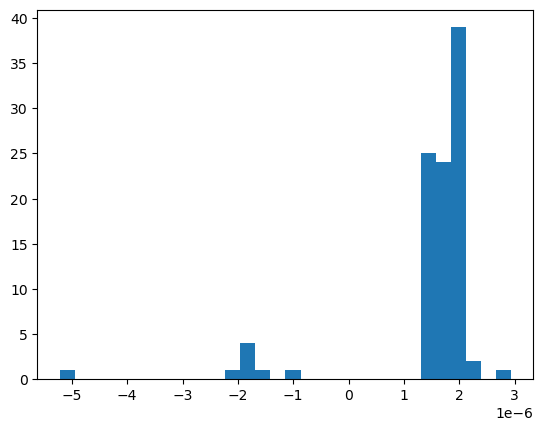

In [635]:
plt.hist(mval[1],bins=30)